# **Install Library**

In [4]:
# 1. Install ObsPy
!pip install obspy --quiet
!pip install matplotlib pandas seaborn --quiet
!pip install obspy matplotlib numpy scipy

# **Import Library**

In [5]:
# Verifikasi instalasi
import obspy
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from obspy.signal.tf_misfit import cwt
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.core import read
from obspy import read, UTCDateTime
from obspy.signal.filter import bandpass
from obspy.signal.trigger import classic_sta_lta, trigger_onset, pk_baer

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 12, 8
print("ObsPy version:", obspy.__version__)

ObsPy version: 1.4.2


# **Mount Google Drive**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

# folder target
!mkdir -p /content/drive/MyDrive/obspy_examples


Mounted at /content/drive


# **Load Dataset From IRIS**

In [7]:
client = Client("IRIS")

In [8]:
threechannels = read('https://examples.obspy.org/COP.BHE.DK.2009.050')
threechannels += read('https://examples.obspy.org/COP.BHN.DK.2009.050')
threechannels += read('https://examples.obspy.org/COP.BHZ.DK.2009.050')
print(threechannels)

3 Trace(s) in Stream:
DK.COP..BHE | 2009-02-19T00:00:00.035100Z - 2009-02-19T23:59:59.985100Z | 20.0 Hz, 1728000 samples
DK.COP..BHN | 2009-02-19T00:00:00.025100Z - 2009-02-19T23:59:59.975100Z | 20.0 Hz, 1728000 samples
DK.COP..BHZ | 2009-02-19T00:00:00.025100Z - 2009-02-19T23:59:59.975100Z | 20.0 Hz, 1728000 samples


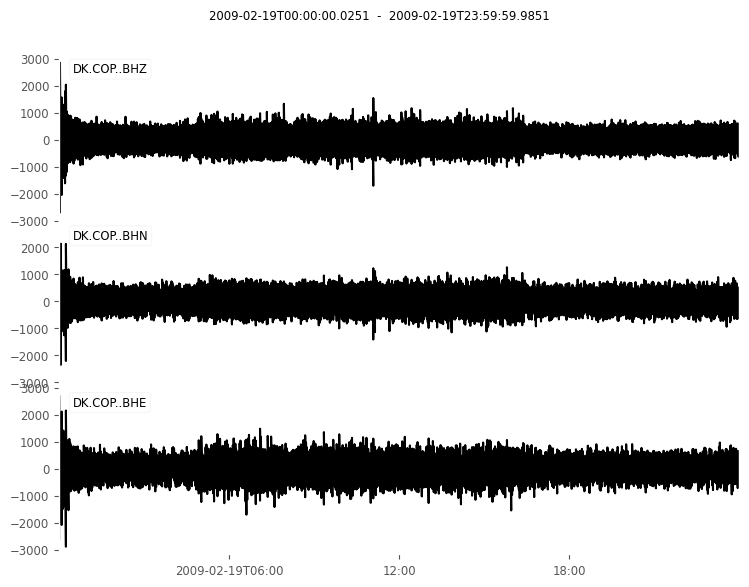

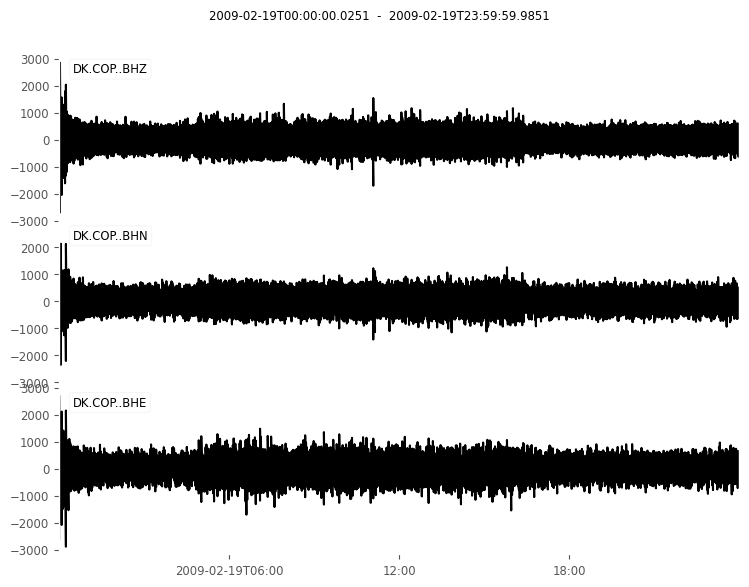

In [9]:
threechannels.plot(size=(800, 600))

# **Load Dataset From USGS**

In [10]:
c_event = Client("USGS")

# Event time.
event_time = obspy.UTCDateTime("2011-03-11T05:46:23.2")

# Get the event information. The temporal and magnitude constraints make it unique
cat = c_event.get_events(starttime=event_time - 10, endtime=event_time + 10,
                         minmagnitude=9)
print(cat)

c = Client("IRIS")
# Download station information at the response level!
inv = c.get_stations(network="II", station="BFO", location="*", channel="BH?",
                     starttime=event_time - 60, endtime=event_time + 3600,
                     level="response")
print(inv)

# Download 3 component waveforms.
st = c.get_waveforms(network="II", station="BFO", location="*",
                     channel="BH?", starttime=event_time - 60,
                     endtime=event_time + 3600)
print(st)


1 Event(s) in Catalog:
2011-03-11T05:46:24.120000Z | +38.297, +142.373 | 9.1  mww | manual
Inventory created at 2025-12-03T09:57:57.209000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2011-03-...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			II
		Stations (1):
			II.BFO (Black Forest Observatory, Schiltach, Germany)
		Channels (3):
			II.BFO.00.BHZ, II.BFO.00.BHN, II.BFO.00.BHE
3 Trace(s) in Stream:
II.BFO.00.BHE | 2011-03-11T05:45:23.215600Z - 2011-03-11T06:46:23.165251Z | 20.0 Hz, 73200 samples
II.BFO.00.BHN | 2011-03-11T05:45:23.215100Z - 2011-03-11T06:46:23.164751Z | 20.0 Hz, 73200 samples
II.BFO.00.BHZ | 2011-03-11T05:45:23.215300Z - 2011-03-11T06:46:23.164951Z | 20.0 Hz, 73200 samples


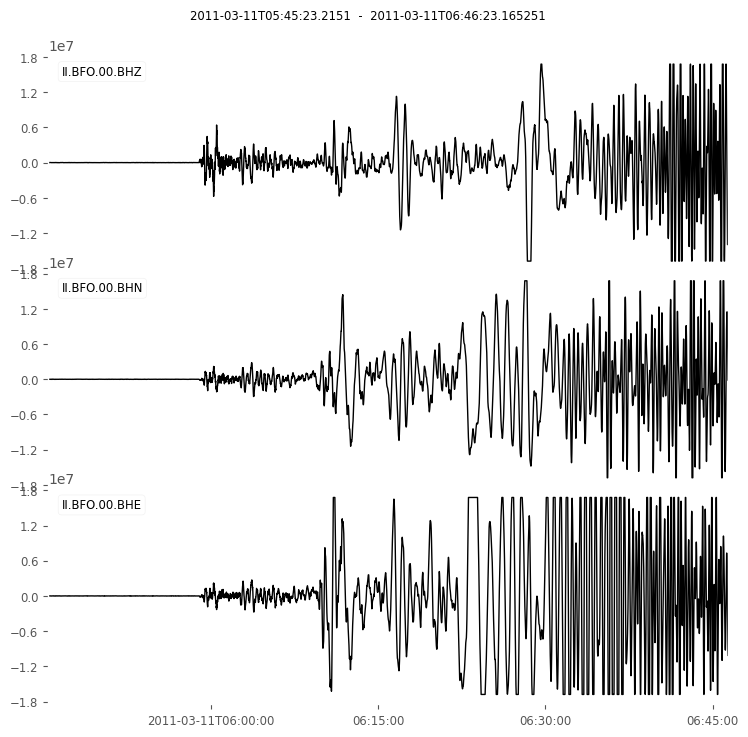

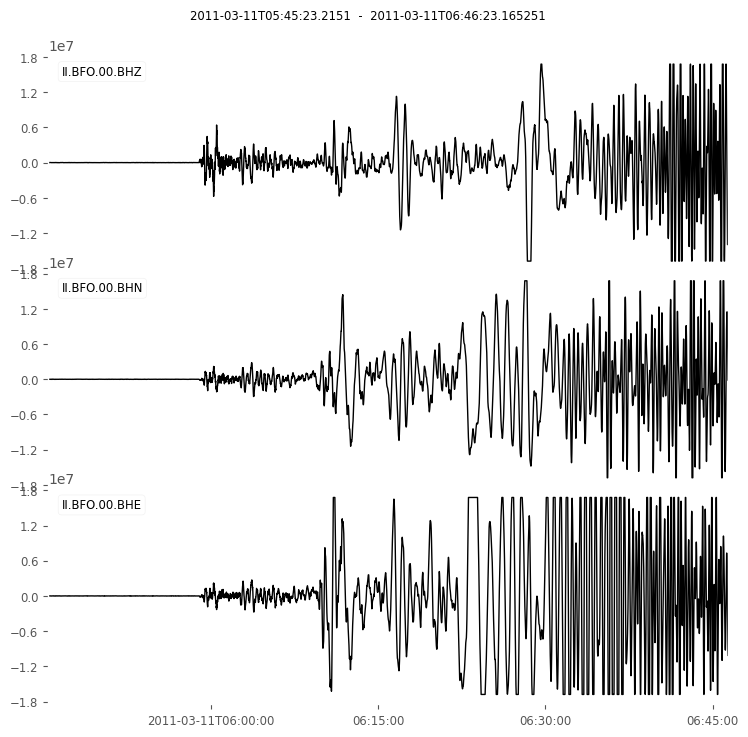

In [11]:
st.plot()

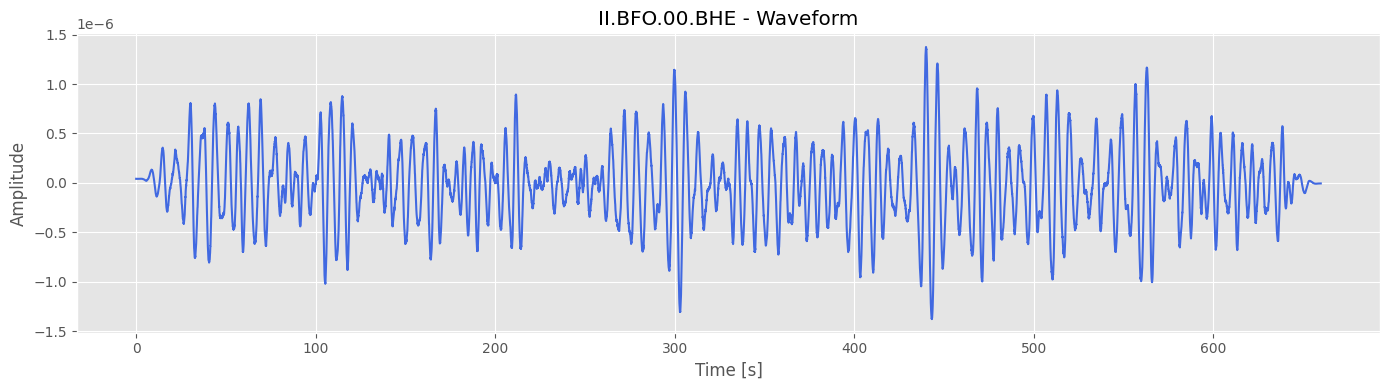

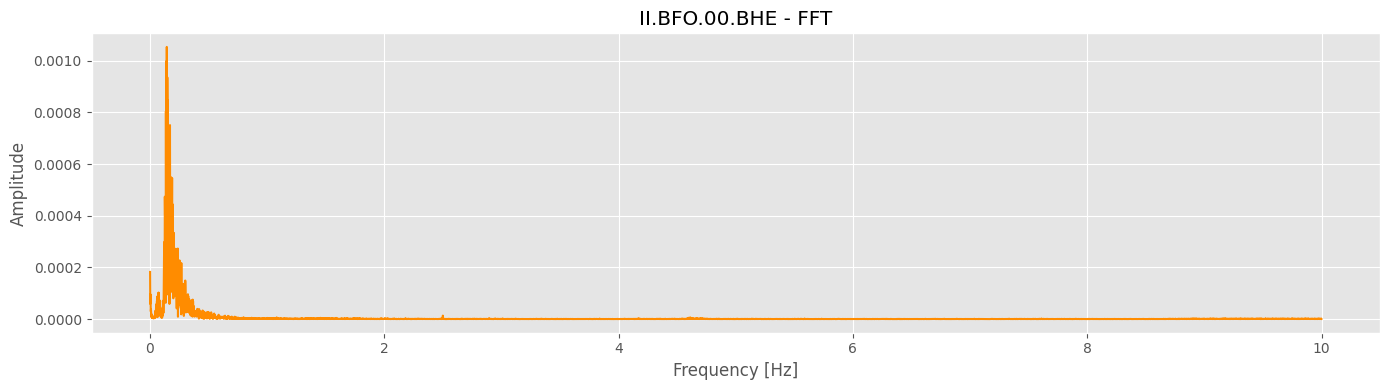

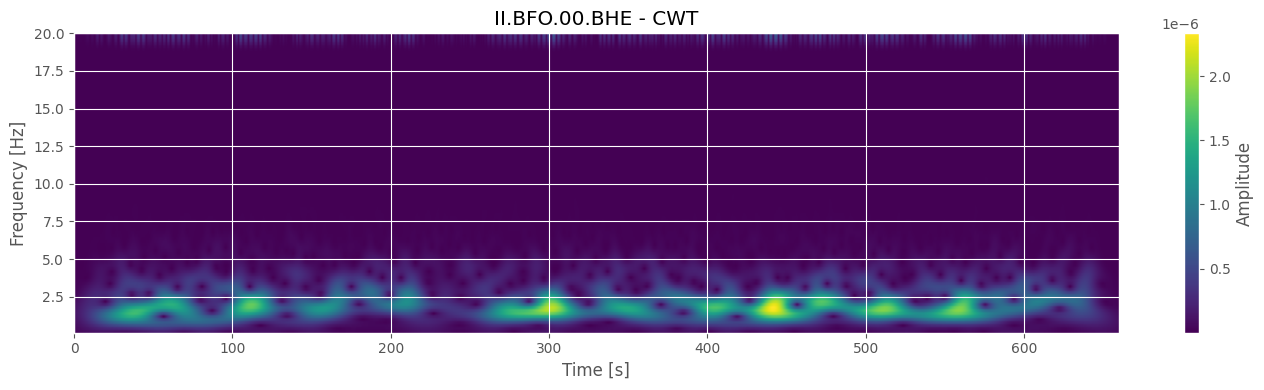

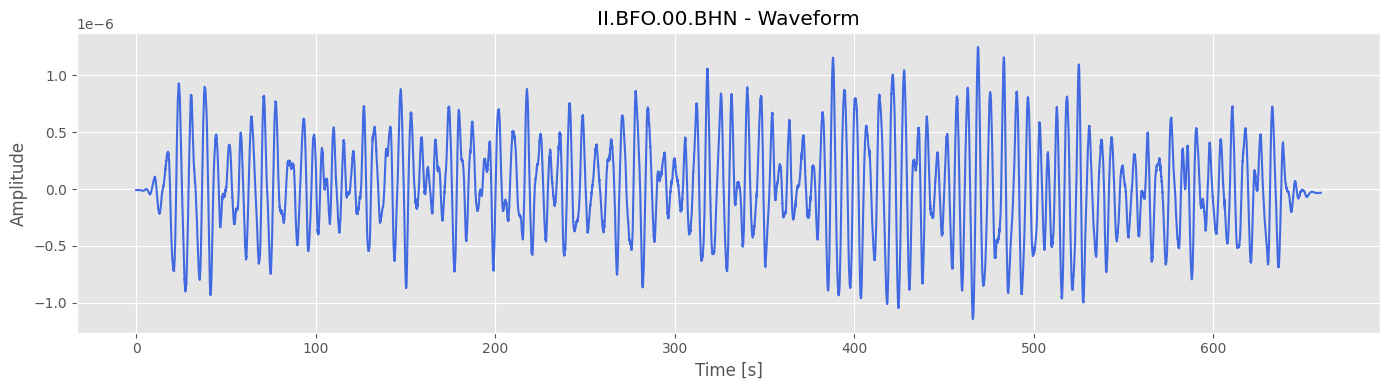

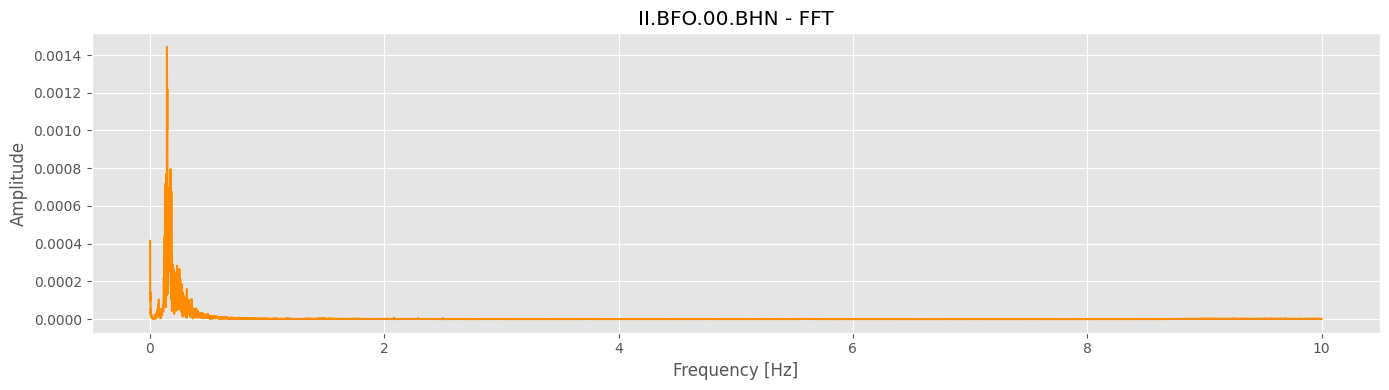

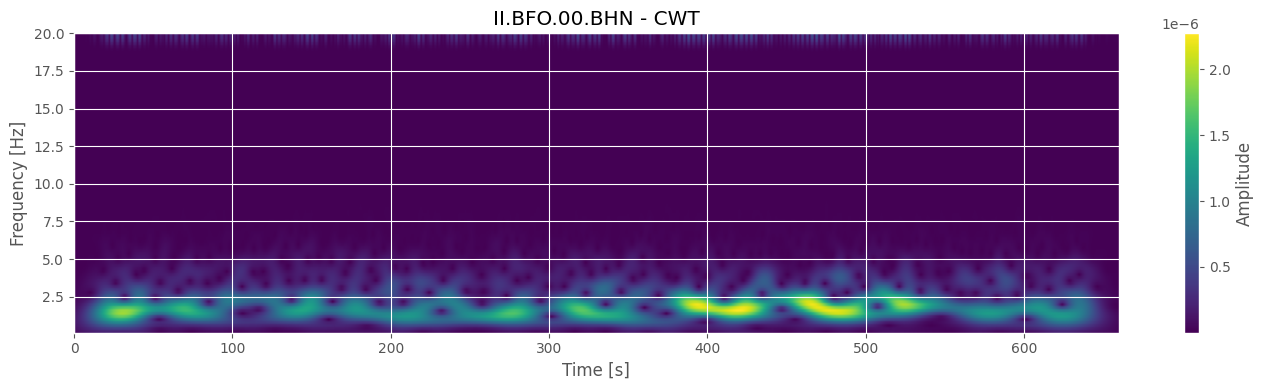

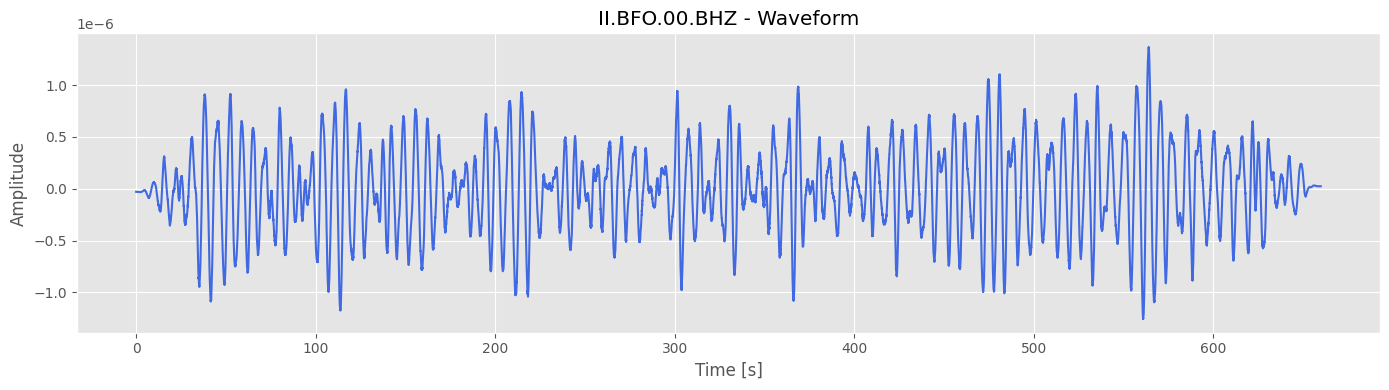

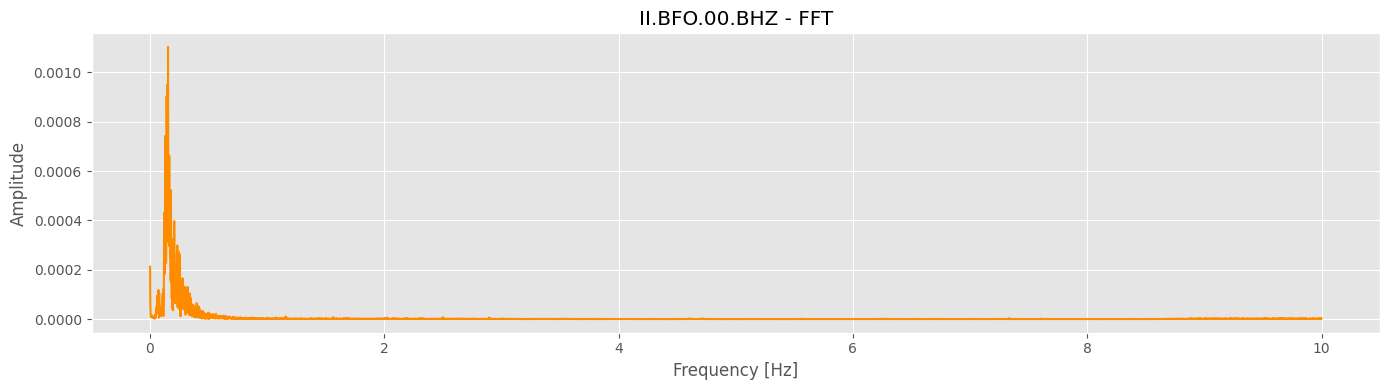

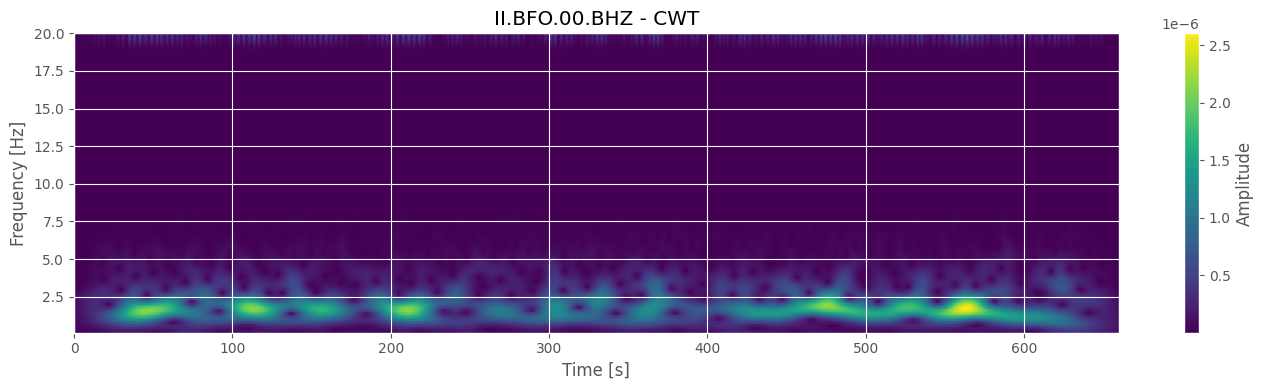

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from obspy.signal.tf_misfit import cwt
from scipy.fft import fft, fftfreq

# Loop per trace (channel)
for tr in st:
    data = tr.data
    npts = tr.stats.npts
    delta = tr.stats.delta
    times = np.arange(npts) * delta

    # =========================
    # Plot Waveform
    # =========================
    plt.figure(figsize=(14, 4))
    plt.plot(times, data, color='royalblue')
    plt.title(f"{tr.id} - Waveform")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # =========================
    # Plot FFT
    # =========================
    fft_vals = fft(data)
    fft_freq = fftfreq(npts, delta)

    # Hanya ambil frekuensi positif
    idx = fft_freq > 0
    plt.figure(figsize=(14, 4))
    plt.plot(fft_freq[idx], np.abs(fft_vals[idx]), color='darkorange')
    plt.title(f"{tr.id} - FFT")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # =========================
    # Plot CWT
    # =========================
    f_min = 0.1
    f_max = 20
    nfreq = 100
    scalogram = cwt(data, delta, 8, fmin=f_min, fmax=f_max, nf=100)

    plt.figure(figsize=(14, 4))
    plt.imshow(np.abs(scalogram), aspect='auto', extent=[times[0], times[-1], f_min, f_max],
               origin='lower', cmap='viridis')
    plt.title(f"{tr.id} - CWT")
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")
    plt.colorbar(label="Amplitude")
    plt.tight_layout()
    plt.show()


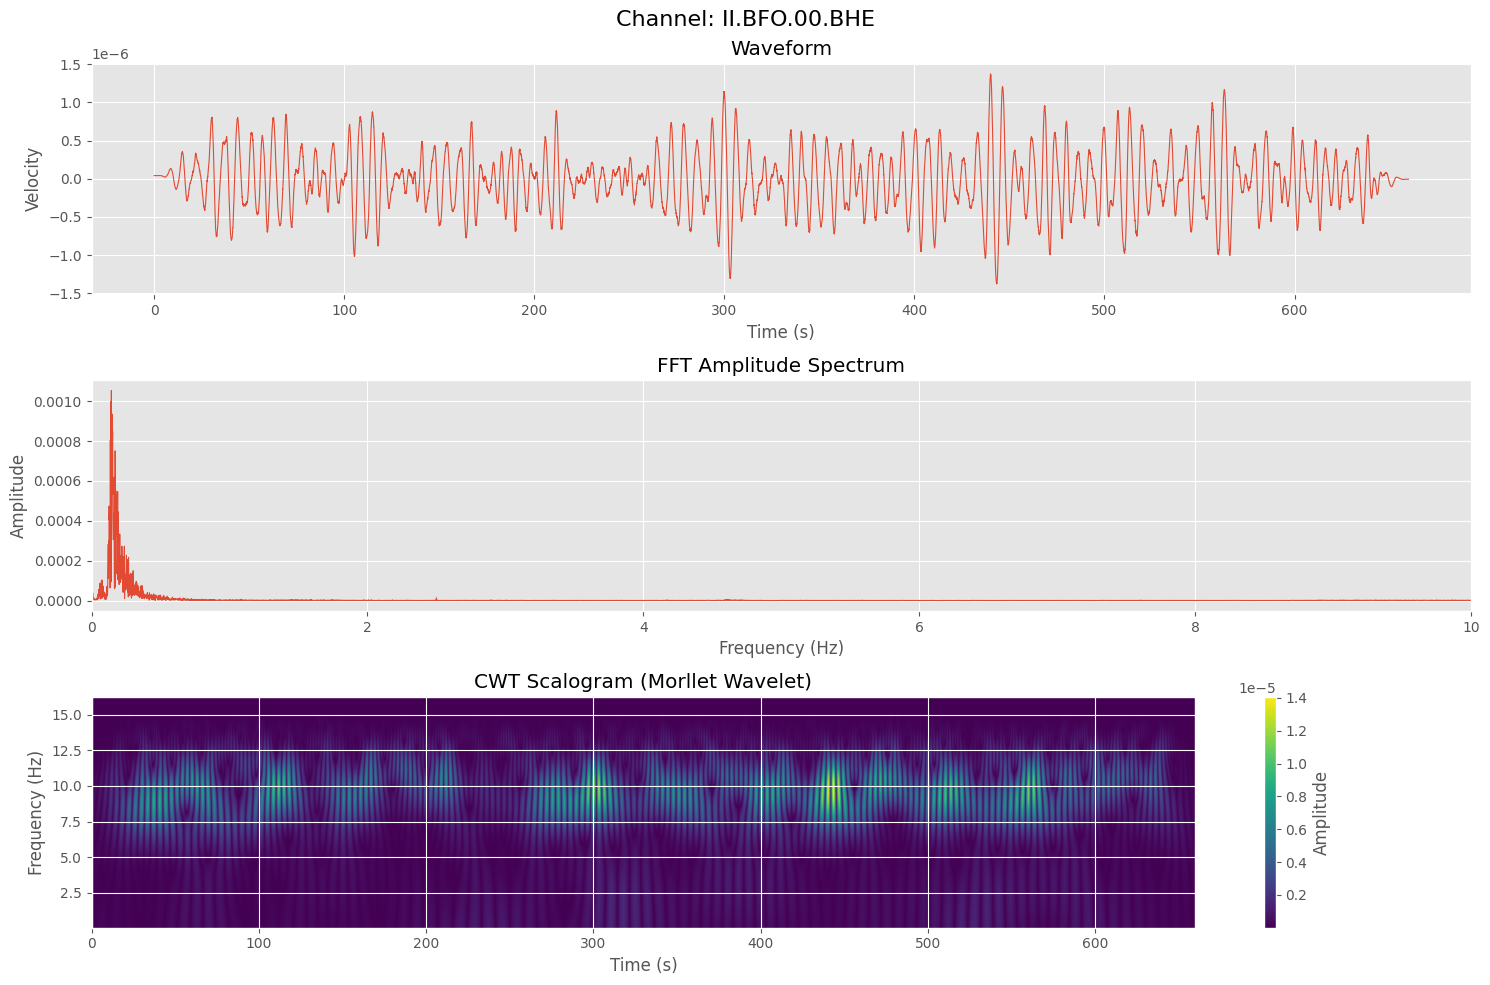

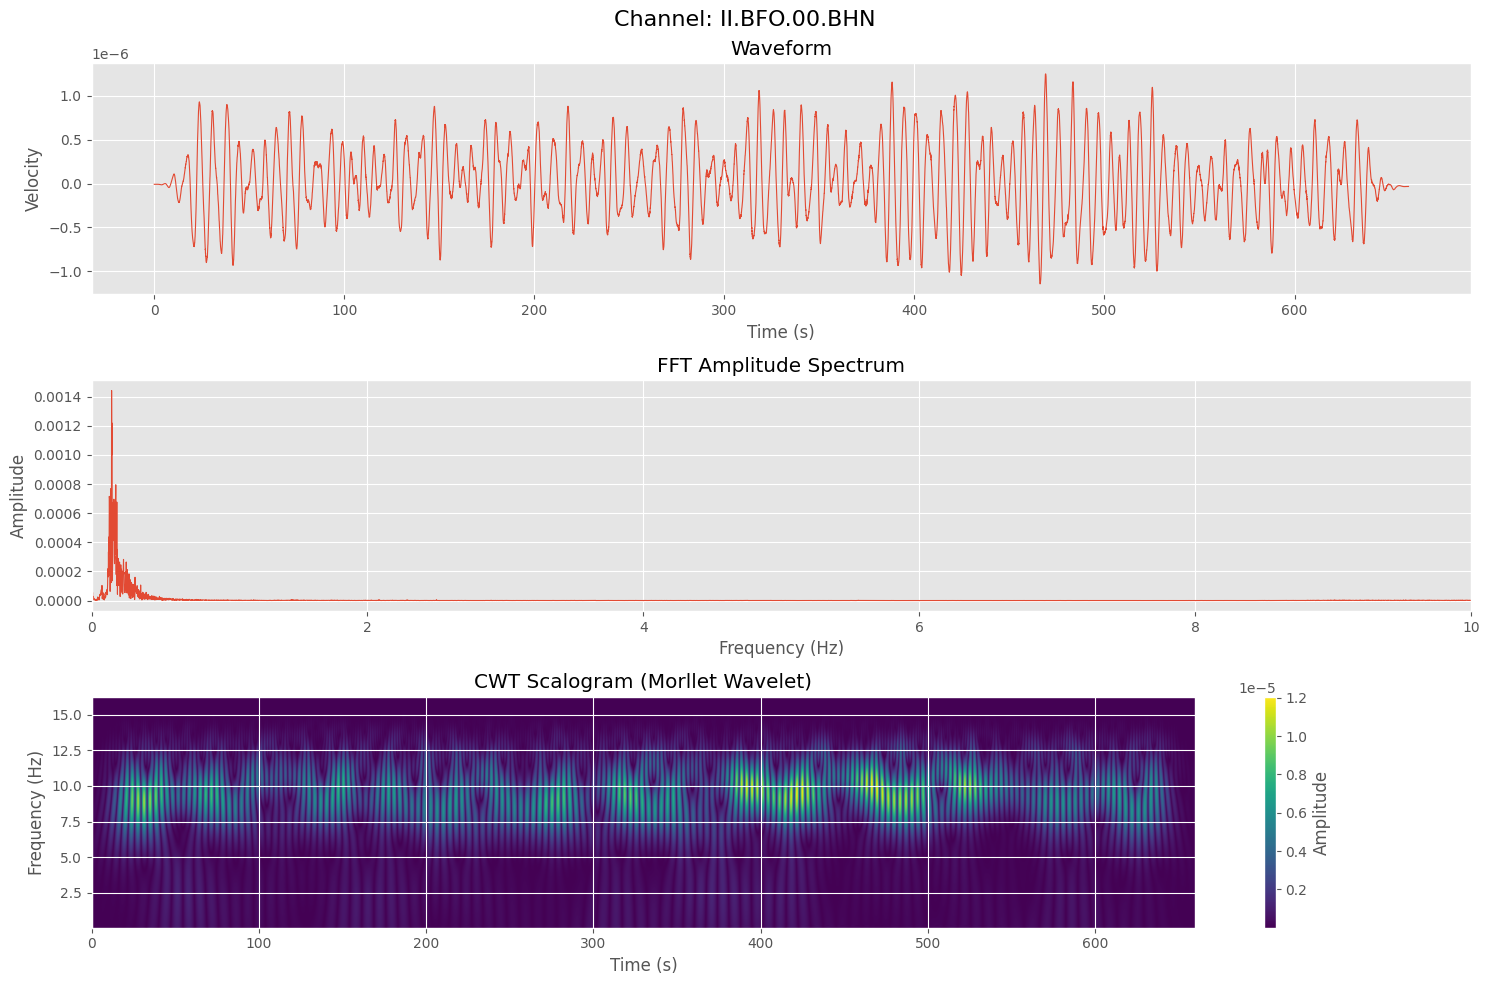

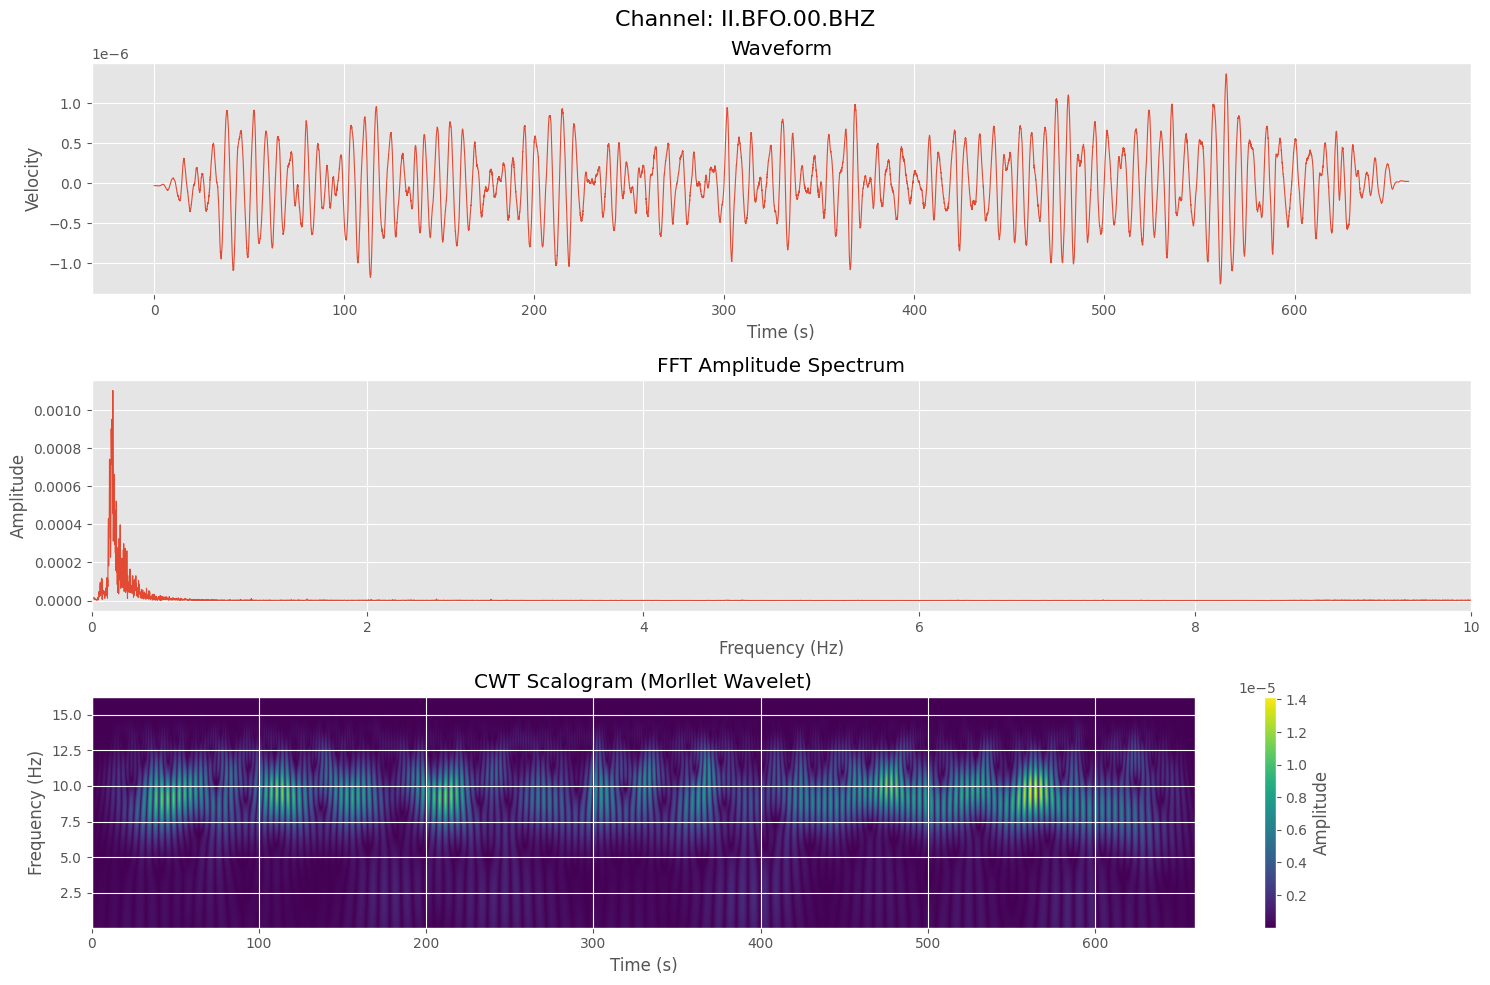

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

client = Client("IRIS")

event_time = UTCDateTime("2011-03-11T05:46:23")

# ============================
# 1. Download Inventory & Data
# ============================
inv = client.get_stations(
    network="II",
    station="BFO",
    location="00",
    channel="BH?",
    starttime=event_time - 60,
    endtime=event_time + 600,
    level="response"
)

st = client.get_waveforms(
    network="II",
    station="BFO",
    location="00",
    channel="BH?",
    starttime=event_time - 60,
    endtime=event_time + 600
)

# ============================
# 2. Preprocessing
# ============================
st.detrend("linear")
st.detrend("demean")
st.taper(max_percentage=0.05)
st.remove_response(inventory=inv, output="VEL")
st.filter("lowpass", freq=10)

# ============================
# 3. Plot per Channel
# ============================
for tr in st:
    data = tr.data
    dt = tr.stats.delta
    n = len(data)
    t = np.arange(0, n * dt, dt)

    # ---------- FFT ----------
    fft_vals = np.fft.rfft(data)
    freqs = np.fft.rfftfreq(n, dt)
    amp = np.abs(fft_vals)

    # ---------- CWT ----------
    scales = np.arange(1, 256)
    coefficients, frequencies = pywt.cwt(data, scales, 'morl', sampling_period=dt)

    # ---------- Plot ----------
    fig, axes = plt.subplots(3, 1, figsize=(15, 10))
    fig.suptitle(f"Channel: {tr.id}", fontsize=16)

    # 1. Time-series
    axes[0].plot(t, data, linewidth=0.8)
    axes[0].set_title("Waveform")
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Velocity")

    # 2. FFT Spectrum
    axes[1].plot(freqs, amp, linewidth=0.8)
    axes[1].set_title("FFT Amplitude Spectrum")
    axes[1].set_xlabel("Frequency (Hz)")
    axes[1].set_ylabel("Amplitude")
    axes[1].set_xlim(0, 10)   # fokus 0–10 Hz (lebih bagus)

    # 3. CWT Scalogram
    im = axes[2].imshow(
        abs(coefficients),
        extent=[0, t[-1], frequencies[-1], frequencies[0]],
        cmap='viridis',
        aspect='auto'
    )
    axes[2].set_title("CWT Scalogram (Morllet Wavelet)")
    axes[2].set_xlabel("Time (s)")
    axes[2].set_ylabel("Frequency (Hz)")
    fig.colorbar(im, ax=axes[2], label="Amplitude")

    plt.tight_layout()
    plt.show()
